This is a notebook to generate mel-spectrograms from a TTS model to be used in a Vocoder training.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import torch
import importlib
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm
from torch.utils.data import DataLoader
from TTS.tts.datasets.dataset import TTSDataset
from TTS.tts.layers.losses import L1LossMasked
from TTS.utils.audio import AudioProcessor
from TTS.config import load_config
from TTS.vocoder.models import setup_model
from TTS.utils.generic_utils import get_npy_path
from TTS.vocoder.datasets.preprocess import load_data_from_splits
from TTS.tts.utils.synthesis import trim_silence

%matplotlib inline

import os
from pathlib import Path
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
BASE_DIR = '/home/perry/PycharmProjects/TTS/recipes/ljspeech/prune_vocoder/'
DATA_DIR = "/home/perry/PycharmProjects/TTS/recipes/ljspeech/LJSpeech-1.1/"
TEST_CSV = DATA_DIR + "splits/test.csv"
MODEL_DIR = BASE_DIR + "coqui_tts-20220128_1245-febb93cf/"
CONFIG_PATH = MODEL_DIR + "config.json"
MODEL_FILE = MODEL_DIR + "checkpoint_200000.pth.tar"
MODEL_FILE2 = MODEL_DIR + "best_model_49780.pth.tar"
BATCH_SIZE = 32
WAV_OUT_DIR = MODEL_DIR + "wav_pwg/"
TTM_DIR = '/home/perry/PycharmProjects/TTS/recipes/ljspeech/prune/coqui_tts-20220121_2029-0938d9e2/'
MEL_DIR = TTM_DIR + 'mel/'
TTM_CONFIG_PATH = TTM_DIR + "config.json"

In [3]:


DRY_RUN = False   # if False, does not generate output files, only computes loss and visuals.

use_cuda = torch.cuda.is_available()
print(" > CUDA enabled: ", use_cuda)

C = load_config(CONFIG_PATH)
ap = AudioProcessor(**C.audio)

 > CUDA enabled:  True
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20.0
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:45.0
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024


In [4]:
C.max_decoder_steps = 1000

In [5]:
# TODO: multiple speaker
model = setup_model(C)
model.load_checkpoint(C, MODEL_FILE, eval=True)

 > Vocoder Model: parallel_wavegan
 > Generator Model: parallel_wavegan_generator
 > Discriminator Model: parallel_wavegan_discriminator


In [6]:
model = model.cuda()

In [7]:
model2 = setup_model(C)
model2.load_checkpoint(C, MODEL_FILE2, eval=True)
model2 = model2.cuda()

 > Vocoder Model: parallel_wavegan
 > Generator Model: parallel_wavegan_generator
 > Discriminator Model: parallel_wavegan_discriminator


In [8]:
test_items = load_data_from_splits(TEST_CSV,
                                   mel_cache_path=MEL_DIR,
                                   )


In [9]:
os.makedirs(WAV_OUT_DIR, exist_ok=True)

In [10]:
for wav_path, mel_path in test_items:
    spec = np.load(mel_path)
    break

In [11]:
gt_spec = np.load(DATA_DIR + 'mel/' + os.path.basename(mel_path))

In [12]:
gt_spec.shape

(80, 718)

In [13]:
if use_cuda:
    device_type = "cuda"
else:
    device_type = "cpu"


In [14]:
ttm_config = load_config(TTM_CONFIG_PATH)
ttm_ap = AudioProcessor(**ttm_config.audio)



 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20.0
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60.0
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:1024


In [15]:
spec = ttm_ap.denormalize(spec.T)

In [16]:
vocoder_input = ap.normalize(spec).T

In [17]:
vocoder_input = torch.tensor(vocoder_input).unsqueeze(0)

In [18]:
vocoder_input = torch.tensor(gt_spec).unsqueeze(0)

In [19]:
vocoder_input.shape

torch.Size([1, 80, 718])

In [20]:
# run vocoder model
# [1, T, C]
waveform = model.inference(vocoder_input.to(device_type))
if use_cuda:
    waveform = waveform.cpu()
waveform = waveform.numpy()
waveform = waveform.squeeze()

# trim silence
waveform = trim_silence(waveform, ap)

ap.save_wav(waveform, os.path.join(WAV_OUT_DIR, Path(mel_path).stem + 'gtmel.wav'))

In [21]:
# run vocoder model
# [1, T, C]
waveform2 = model2.inference(vocoder_input.to(device_type))
if use_cuda:
    waveform2 = waveform2.cpu()
waveform2 = waveform2.numpy()
waveform2 = waveform2.squeeze()

# trim silence
waveform2 = trim_silence(waveform, ap)

ap.save_wav(waveform2, os.path.join(WAV_OUT_DIR, Path(mel_path).stem + '_3gtmel.wav'))

In [37]:
waveform

array([ 1.4348991e-02,  1.5364431e-02,  1.7897867e-02, ...,
        9.2371553e-04, -5.6557357e-05,  1.4566630e-04], dtype=float32)

In [15]:
vocoder_input = vocoder_input.transpose(1, 2)
waveform = model.inference(vocoder_input.to(device_type))

In [8]:
with torch.no_grad():
    os.makedirs(WAV_OUT_DIR, exist_ok=True)
    for batch in loader:
        char_ids = batch["char_ids"]
        wav_path = batch["wav_path"]
        mel_gts = batch["mel"]
        mel_lengths = batch["mel_lengths"]

        # dispatch data to GPU
        if use_cuda:
            char_ids = char_ids.cuda()

        results = model.inference(char_ids)

        model_outputs = results['model_outputs']
        decoder_outputs = results['decoder_outputs']
        alignments = results['alignments']
        stop_tokens = results['stop_tokens']

        for model_output, mel_gt_length, wav_file in zip(model_outputs, mel_lengths, wav_path):
            # plot posnet output
            model_out = model_output[:mel_gt_length, :]
            # plot_spectrogram(model_outputs[idx], ap)
            spectrogram = model_out.detach().cpu().numpy().squeeze().T
            np.save(get_npy_path(MEL_OUT_DIR, wav_file), spectrogram)
            # wav = ap.inv_melspectrogram(spectrogram)
            # ap.save_wav(wav, os.path.join(WAV_OUT_DIR, os.path.basename(wav_file)))

   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_decoder_steps` 1000
   > Decoder stopped with `max_

In [9]:
import matplotlib.pyplot as plt
plt.imshow(spectrogram, aspect="auto", origin="lower", cmap='viridis')

### Generate model outputs 

In [10]:
import pickle

file_idxs = []
metadata = []
losses = []
postnet_losses = []
criterion = L1LossMasked(seq_len_norm=C.seq_len_norm)
with torch.no_grad():
    for data in tqdm(loader):
        # setup input data
        char_ids = data["char_ids"]
        id_lengths = data["id_lengths"]
        linear_input = data["linear"]
        stop_targets = data["stop_targets"]
        wav_path = data["wav_path"]

        # dispatch data to GPU
        if use_cuda:
            char_ids = char_ids.cuda()
            id_lengths = id_lengths.cuda()
            mel_input = mel_input.cuda()
            mel_lengths = mel_lengths.cuda()

        mask = sequence_mask(id_lengths)
        mel_outputs, postnet_outputs, alignments, stop_tokens = model.forward(char_ids, id_lengths)
        
        # compute loss
        loss = criterion(mel_outputs, mel_input, mel_lengths)
        loss_postnet = criterion(postnet_outputs, mel_input, mel_lengths)
        losses.append(loss.item())
        postnet_losses.append(loss_postnet.item())

        mels = postnet_outputs.detach().cpu().numpy()
        alignments = alignments.detach().cpu().numpy()

        if not DRY_RUN:
            os.makedirs(MEL_OUT_DIR, exist_ok=True)
            os.makedirs(WAV_OUT_DIR, exist_ok=True)
            wavs_gl = apply_griffin_lim(mels, mel_lengths)
            for idx in range(char_ids.shape[0]):
                wav_file = wav_path[idx]

                # save TTS mel
                mel = mels[idx]
                mel_length = mel_lengths[idx]
                mel = mel[:mel_length, :].T
                np.save(get_npy_path(MEL_OUT_DIR, wav_file), mel)



    print(np.mean(losses))
    print(np.mean(postnet_losses))

  0%|          | 0/2 [00:00<?, ?it/s]


NameError: name 'mel_input' is not defined

### Sanity Check

torch.Size([32, 3000, 80])


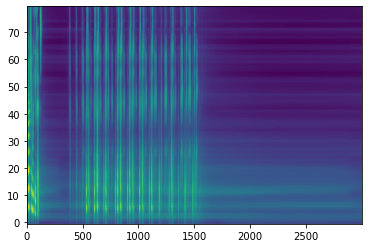

In [ ]:
# plot decoder output
print(postnet_outputs.shape)
plot_spectrogram(postnet_outputs, ap)

torch.Size([859, 80])


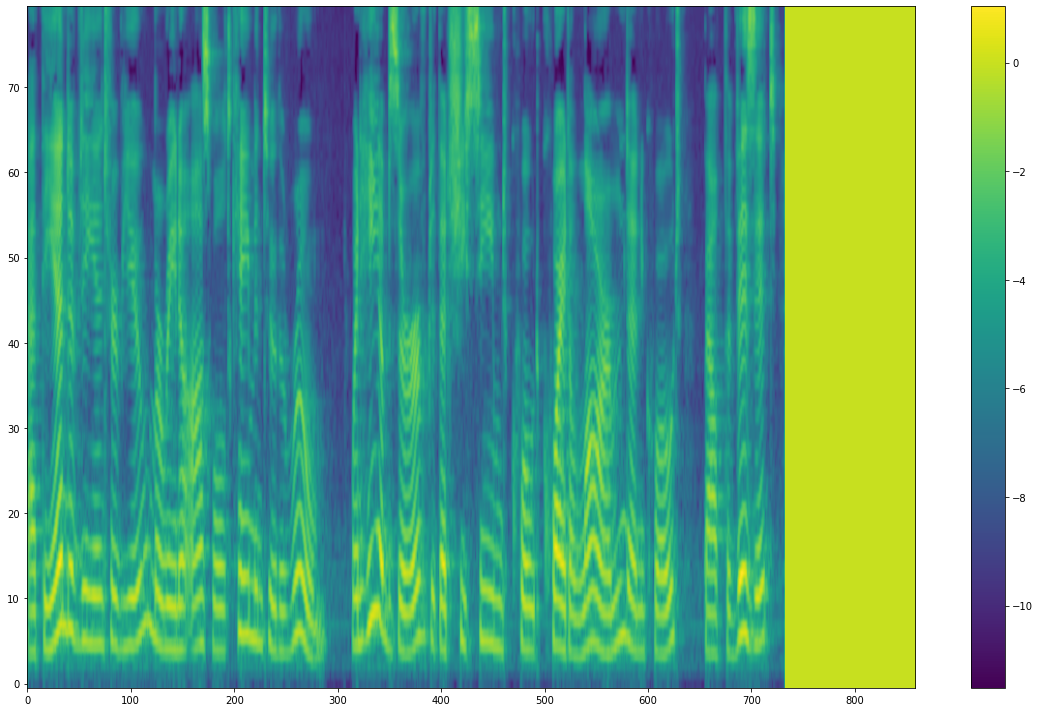

In [39]:
# plot GT specgrogram
print(mel_gts[idx].shape)
plot_spectrogram(mel_gts[idx], ap)

In [ ]:
# postnet, decoder diff
from matplotlib import pylab as plt
mel_diff = mel_decoder - mel_postnet
plt.figure(figsize=(16, 10))
plt.imshow(abs(mel_diff[:mel_lengths[idx],:]).T,aspect="auto", origin="lower");
plt.colorbar()
plt.tight_layout()

In [ ]:
# PLOT GT SPECTROGRAM diff
from matplotlib import pylab as plt
mel_diff2 = mel_truth.T - mel_decoder
plt.figure(figsize=(16, 10))
plt.imshow(abs(mel_diff2).T,aspect="auto", origin="lower");
plt.colorbar()
plt.tight_layout()

In [ ]:
# PLOT GT SPECTROGRAM diff
from matplotlib import pylab as plt
mel = postnet_outputs[idx]
mel_diff2 = mel_truth.T - mel[:mel_truth.shape[1]]
plt.figure(figsize=(16, 10))
plt.imshow(abs(mel_diff2).T,aspect="auto", origin="lower");
plt.colorbar()
plt.tight_layout()